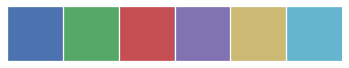

In [1]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.animation import FuncAnimation
from tempfile import NamedTemporaryFile
from IPython.display import HTML
import seaborn as sns
import numpy as np
import six
import tensorflow as tf

plt.style.use('seaborn-talk')
sns.set_context("talk", font_scale=1.4)
# sns.set_palette("colorblind")
sess = ed.get_session()

sns.palplot(sns.color_palette())

In [2]:
# this can be done only before using Edward
ed.set_seed(42)

In [ ]:
VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, fps=20, extra_args=['-vcodec', 'libx264'])
            video = open(f.name, "rb").read()
        anim._encoded_video = video.encode("base64")
    
    return VIDEO_TAG.format(anim._encoded_video)

In [ ]:
# VIDEO_TAG = """<video controls>
#  <source src="data:video/x-webm;base64,{0}" type="video/webm">
#  Your browser does not support the video tag.
# </video>"""

# def anim_to_html(anim):
#     if not hasattr(anim, '_encoded_video'):
#         with NamedTemporaryFile(suffix='.webm') as f:
#             anim.save(f.name, fps=12,
#                       extra_args=['-vcodec', 'libvpx',
#                                   '-g', '120',
#                                   '-level', '216',
#                                   '-profile', '0',
#                                   '-qmax', '42',
#                                   '-qmin', '10', 
#                                   '-rc_buf_aggressivity', '0.95',
#                                   '-vb', '2M'])
#             video = open(f.name, "rb").read()
#         anim._encoded_video = video.encode("base64")

#     return VIDEO_TAG.format(anim._encoded_video)

In [ ]:
def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))

# Coin

In [ ]:
from edward.models import Bernoulli, Beta, Empirical, Uniform

In [ ]:
N = 100  # number of coin flip observations in dataset

In [ ]:
def build_fair_dataset(N):
    pheads = tf.constant(0.5)
    c = Bernoulli(probs=pheads, sample_shape=N)
    return sess.run([pheads, c])

In [ ]:
def build_unfair_dataset(N):
    pheads = tf.constant(0.05)
    c = Bernoulli(probs=pheads, sample_shape=N)
    return sess.run([pheads, c])

In [ ]:
def build_dataset(N):
    pheads = Uniform(low=0.0, high=1.0)
    c = Bernoulli(probs=pheads, sample_shape=N)
    return sess.run([pheads, c])

In [ ]:
x = tf.range(-0.2, 1.2, 0.001)
plt.plot(*sess.run([x, Uniform(low=0.0, high=1.0).prob(x)]));
#plt.plot(*sess.run([x, Beta(concentration1=1.0, concentration0=1.0).prob(x)]));
plt.ylim((-0.2, 1.2));

In [ ]:
# DATA
pheads_true, c_train = build_fair_dataset(N)

In [ ]:
pheads_true

In [ ]:
c_train

In [ ]:
sum(c_train == 0)

In [ ]:
sum(c_train == 1)

In [ ]:
pheads_fair = Beta(concentration1=1000.0, concentration0=1000.0)  # blue
pheads_unfair = Beta(concentration1=0.1, concentration0=0.1)  # green
pheads_unknown = Beta(concentration1=1.0, concentration0=1.0)  # red

In [ ]:
x = tf.range(0.0, 1.0, 0.001)
plt.plot(*sess.run([x, pheads_fair.prob(x)]));
plt.plot(*sess.run([x, pheads_unfair.prob(x)]));
plt.plot(*sess.run([x, pheads_unknown.prob(x)]));
plt.axvline(x=pheads_true);

In [ ]:
# FORWARD MODEL
pheads = pheads_unknown
c = Bernoulli(probs=pheads, sample_shape=N)

#### Exact Solution

In [ ]:
# INFERENCE
pheads_cond = ed.complete_conditional(pheads)
pheads_post = ed.copy(pheads_cond, {c: c_train})

In [ ]:
sess.run({key: val for
          key, val in six.iteritems(pheads_post.parameters)
          if isinstance(val, tf.Tensor)})

In [ ]:
# CRITICISM
mean, stddev = sess.run([pheads_post.mean(), pheads_post.stddev()])
print("Exact posterior mean:")
print(mean)
print("Exact posterior std:")
print(stddev)

In [ ]:
x = tf.range(0.0, 1.0, 0.001)
plt.plot(*sess.run([x, pheads.prob(x)]));  # blue
plt.plot(*sess.run([x, pheads_post.prob(x)]));  # green
plt.axvline(x=pheads_true);  # blue

In [ ]:
# this can take a minute
fig = plt.figure()
ax = plt.axes(xlim=(-0.05, 1.05), ylim=(-1.0, 11.0))

def go(pheads_prior, sample_shape, c_train):
    # MODEL
    c = Bernoulli(probs=pheads_prior,
                  sample_shape=sample_shape)
    # INFERENCE
    pheads_cond = ed.complete_conditional(pheads_prior)
    pheads_post = ed.copy(pheads_cond, {c: c_train[:sample_shape]})
    
    # CRITICISM
    ax.plot(*sess.run([x, pheads_post.prob(x)]));
    
    # RECURSION
    if len(c_train[sample_shape:]) >= sample_shape:
        go(pheads_post, sample_shape, c_train[sample_shape:])

pheads_prior = Beta(concentration1=1.0, concentration0=1.0)
ax.plot(*sess.run([x, pheads_prior.prob(x)]));  # blue
plt.axvline(x=pheads_true);  # blue
go(pheads_prior, 33, c_train)

#### MCMC: Metropolis Hastings

In [ ]:
# BACKWARD MODEL
T = 10000  # number of empirical samples
q_pheads = Empirical(params=tf.Variable(tf.ones([T])*.5))

In [ ]:
# INFERENCE
proposal_pheads = Beta(concentration1=1.0,
                       concentration0=1.0)
inference = ed.MetropolisHastings(latent_vars={pheads: q_pheads},
                                  proposal_vars={pheads: proposal_pheads},
                                  data={c: c_train})
inference.run()

In [ ]:
# CRITICISM
mean, stddev = sess.run([q_pheads.mean(), q_pheads.stddev()])
print("Inferred posterior mean:")
print(mean)
print("Inferred posterior std:")
print(stddev)

In [ ]:
plt.plot(q_pheads.params.eval());
plt.axhline(y=pheads_true);

In [ ]:
def lags(x):
    mean = tf.reduce_mean(x)
    var = tf.cast(tf.size(x) - 1, tf.float32) * tf.reduce_mean(tf.square(x - mean))
    ret = tf.map_fn(lambda k: tf.cond(tf.equal(k, 0),
                                      lambda: var,
                                      lambda: tf.reduce_sum((x[:-k] - mean) * (x[k:] - mean))),
                    tf.range(0, tf.size(x)),
                    dtype=tf.float32)
    return ret / var

In [ ]:
plt.plot(lags(q_pheads.params).eval());

In [ ]:
x = tf.range(0.0, 1.0, 0.001)
plt.plot(*sess.run([x, pheads.prob(x)]));  # blue
plt.plot(*sess.run([x, pheads_cond.prob(x)],  # green
                   {c: c_train}));
plt.hist(q_pheads.params.eval(),  # red
         bins=100, range=(0.0, 1.0),
         normed=True);
plt.axvline(x=pheads_true);  # blue

#### MCMC: Gibbs

In [ ]:
# BACKWARD MODEL
T = 10000  # number of empirical samples
q_pheads = Empirical(params=tf.Variable(tf.ones([T])*.5))

In [ ]:
# INFERENCE
inference = ed.Gibbs(latent_vars={pheads: q_pheads},
                     data={c: c_train})
inference.run()

In [ ]:
# CRITICISM
mean, stddev = sess.run([q_pheads.mean(), q_pheads.stddev()])
print("Inferred posterior mean:")
print(mean)
print("Inferred posterior std:")
print(stddev)

In [ ]:
plt.plot(q_pheads.params.eval());
plt.axhline(y=pheads_true);

In [ ]:
plt.plot(lags(q_pheads.params).eval());

In [ ]:
x = tf.range(0.0, 1.0, 0.001)
plt.plot(*sess.run([x, pheads.prob(x)]));  # blue
plt.plot(*sess.run([x, pheads_cond.prob(x)],  # green
                   {c: c_train}));
plt.hist(q_pheads.params.eval(),  # red
         bins=100, range=(0.0, 1.0),
         normed=True);
plt.axvline(x=pheads_true);  # blue

#### MCMC: Hamiltonian Monte-Carlo

In [ ]:
# BACKWARD MODEL
T = 10000  # number of empirical samples
q_pheads = Empirical(params=tf.Variable(tf.ones([T])*.5))

In [ ]:
# INFERENCE
inference = ed.HMC(latent_vars={pheads: q_pheads},
                   data={c: c_train})
inference.run(step_size=1.0 / N, n_steps=20)

In [ ]:
# CRITICISM
mean, stddev = sess.run([q_pheads.mean(), q_pheads.stddev()])
print("Inferred posterior mean:")
print(mean)
print("Inferred posterior std:")
print(stddev)

In [ ]:
plt.plot(q_pheads.params.eval());
plt.axhline(y=pheads_true);

In [ ]:
plt.plot(lags(q_pheads.params).eval());

In [ ]:
x = tf.range(0.0, 1.0, 0.001)
plt.plot(*sess.run([x, pheads.prob(x)]));  # blue
plt.plot(*sess.run([x, pheads_cond.prob(x)],  # green
                   {c: c_train}));
plt.hist(q_pheads.params.eval(),  # red
         bins=100, range=(0.0, 1.0),
         normed=True);
plt.axvline(x=pheads_true);  # blue

#### Variational Inference (VI)

In [ ]:
# BACKWARD MODEL
q_pheads_concentration1 = tf.nn.softplus(tf.Variable(tf.random_normal([])))
# q_pheads_concentration1 = tf.nn.softplus(tf.Variable(51 + tf.random_normal([])))
q_pheads_concentration0 = tf.nn.softplus(tf.Variable(tf.random_normal([])))
# q_pheads_concentration0 = tf.nn.softplus(tf.Variable(51 + tf.random_normal([])))
q_pheads = Beta(concentration1=q_pheads_concentration1,
                concentration0=q_pheads_concentration0)

In [ ]:
x = tf.range(-5.0, 5.0, 0.001)
plt.plot(*sess.run([x, tf.nn.softplus(x)]));

In [ ]:
# INFERENCE
inference = ed.KLqp(latent_vars={pheads: q_pheads},
                    data={c: c_train})
inference.run(n_samples=20, n_iter=1000)
#inference.run(n_samples=1000, n_iter=1000)

In [ ]:
# T = 10000  # number of empirical samples
# q_pheads_samples = sess.run(q_pheads.sample(sample_shape=T))

In [ ]:
# plt.plot(q_pheads_samples);
# plt.axhline(y=pheads_true);

In [ ]:
sess.run({key: val for
          key, val in six.iteritems(q_pheads.parameters)
          if isinstance(val, tf.Tensor)})

In [ ]:
plt.plot(*sess.run([x, pheads.prob(x)]));  # blue
plt.plot(*sess.run([x, pheads_cond.prob(x)],  # green
                   {c: c_train}));
plt.plot(*sess.run([x, q_pheads.prob(x)]));  # red
# plt.hist(q_pheads_samples,  # red
#          bins=100, range=(0.0, 1.0),
#          normed=True);
plt.axvline(x=pheads_true);  # blue

In [ ]:
# CRITICISM
mean, stddev = sess.run([q_pheads.mean(), q_pheads.stddev()])
print("Inferred posterior mean:")
print(mean)
print("Inferred posterior std:")
print(stddev)

# A/B/... Testing

In [3]:
from edward.models import Beta, Bernoulli, Empirical

In [4]:
def build_dataset(N, concentration1=10.0, concentration0=5.0):
    pheads = Beta(concentration1=concentration1,
                  concentration0=concentration0)
    c = Bernoulli(probs=pheads, sample_shape=N)
    return sess.run([pheads, c])

In [5]:
# DATA
NN = [50, 90, 10, 1000]  # number of flips per coin
pheads_true, c_train = zip(*[build_dataset(N) for N in NN])

In [6]:
pheads_true  # true coin biases (usually unknown)

(0.69634295, 0.76858085, 0.77796137, 0.44616842)

In [ ]:
x = tf.range(0.0, 1.0, 0.001)
plt.plot(*sess.run([x, Beta(concentration1=10.0,
                            concentration0=5.0).prob(x)]));
[plt.axvline(x=pheads_true[i], c=sns.color_palette()[i]) for i, _ in enumerate(pheads_true)];

In [ ]:
c_train

In [ ]:
# FORWARD MODEL
pheads = [Beta(concentration1=10.0, concentration0=5.0) for _ in NN]
c = [Bernoulli(probs=pheads[i], sample_shape=N) for i, N in enumerate(NN)]

In [ ]:
# BACKWARD MODEL
T = 10000  # number of empirical samples
q_pheads = [Empirical(params=tf.Variable(tf.ones([T])*.5)) for _ in NN]

In [ ]:
# INFERENCE
# this will take a couple of minutes
inference = ed.HMC(latent_vars=dict(zip(pheads, q_pheads)),
                   data=dict(zip(c, c_train)))
inference.run(step_size=1.0 / sum(NN), n_steps=20)

In [ ]:
# CRITICISM
[plt.plot(q_pheads[i].params.eval(), alpha=0.7) for i, _ in enumerate(NN)];
[plt.axhline(y=pheads_true[i], c=sns.color_palette()[i]) for i, _ in enumerate(NN)];

In [ ]:
def lags(x):
    mean = tf.reduce_mean(x)
    var = tf.cast(tf.size(x) - 1, tf.float32) * tf.reduce_mean(tf.square(x - mean))
    ret = tf.map_fn(lambda k: tf.cond(tf.equal(k, 0),
                                      lambda: var,
                                      lambda: tf.reduce_sum((x[:-k] - mean) * (x[k:] - mean))),
                    tf.range(0, tf.size(x)),
                    dtype=tf.float32)
    return ret / var

In [ ]:
[plt.plot(lags(q_pheads[i].params).eval(), alpha=0.7) for i, _ in enumerate(NN)];

In [ ]:
x = tf.range(0.0, 1.0, 0.001)
[plt.hist(q_pheads[i].params.eval(),
          bins=100, range=(0.0, 1.0),
          normed=True, alpha=0.7) for i, _ in enumerate(NN)];
[plt.axvline(x=pheads_true[i], c=sns.color_palette()[i]) for i, _ in enumerate(NN)];

In [ ]:
# lift of coin 2 over coin 1 (at least %)
# (at least) by what % is coin 2 more biased towards heads than coin 1?
def get_prob(lift, samples_pheads1, samples_pheads2):
    return tf.map_fn(lambda l: tf.reduce_mean(tf.to_float(tf.greater(
        (samples_pheads2 - samples_pheads1) / samples_pheads1, l))), lift)

x = tf.range(-1.0, 1.0, 0.001)
def plot_prob(ax, i, j):
    ax.plot(*sess.run([x*100, get_prob(x,
                                       q_pheads[i].params[int(T/2):],
                                       q_pheads[j].params[int(T/2):])]))
    ax.set_xlabel('Lift of coin {} over coin {} (at least %)'.format(j, i))
    ax.set_ylabel('Probability')
    ax.set_title('Lift')

fig, ax = plt.subplots(nrows=int(len(NN) * (len(NN) - 1) / 2),
                       ncols=1,
                       figsize=(12.0, 2.0 * len(NN) * (len(NN) - 1)))

k = 0
for i in range(0, len(NN)):
    for j in range(i + 1, len(NN)):
        plot_prob(ax[k], i, j)
        k += 1

plt.tight_layout()

#### For The Adventurous: Hierarchical Model

In [ ]:
from edward.models import Uniform

In [ ]:
# HIERARCHICAL FORWARD MODEL
beta_mean = Uniform(low=0.0, high=1.0)  # prior for beta mean
beta_variance = Uniform(low=0.0, high=beta_mean * (1.0 - beta_mean))  # prior for beta variance
concentration1 = beta_mean * (((1.0 - beta_mean) * beta_mean) / beta_variance - 1.0)
concentration0 = concentration1 * (-1.0 + 1.0 / beta_mean)
pheads = [Beta(concentration1=concentration1,
               concentration0=concentration0) for _ in NN]
c = [Bernoulli(probs=pheads[i], sample_shape=N) for i, N in enumerate(NN)]

In [ ]:
# BACKWARD MODEL
T = 50000  # number of empirical samples
q_beta_mean = Empirical(params=tf.Variable(tf.ones([T])*.5))
q_beta_variance = Empirical(params=tf.Variable(tf.ones([T])*.01))
q_pheads = [Empirical(params=tf.Variable(tf.ones([T])*.5)) for _ in NN]

In [ ]:
# INFERENCE
# this can take 20 minutes
inference = ed.HMC(latent_vars=dict(list(zip(pheads, q_pheads)) +
                                    [(beta_mean, q_beta_mean),
                                     (beta_variance, q_beta_variance)]),
                   data=dict(zip(c, c_train)))
inference.run(step_size=0.1 / sum(NN), n_steps=20)

In [ ]:
# CRITICISM
[plt.plot(q_pheads[i].params.eval(), alpha=0.7) for i, _ in enumerate(NN)];
[plt.axhline(y=pheads_true[i], c=sns.color_palette()[i]) for i, _ in enumerate(NN)];

In [ ]:
def lags(x):
    mean = tf.reduce_mean(x)
    var = tf.cast(tf.size(x) - 1, tf.float32) * tf.reduce_mean(tf.square(x - mean))
    ret = tf.map_fn(lambda k: tf.cond(tf.equal(k, 0),
                                      lambda: var,
                                      lambda: tf.reduce_sum((x[:-k] - mean) * (x[k:] - mean))),
                    tf.range(0, tf.size(x)),
                    dtype=tf.float32)
    return ret / var

In [ ]:
[plt.plot(lags(q_pheads[i].params).eval(), alpha=0.7) for i, _ in enumerate(NN)];

In [ ]:
x = tf.range(0.0, 1.0, 0.001)
[plt.hist(q_pheads[i].params.eval(),
          bins=100, range=(0.0, 1.0),
          normed=True, alpha=0.7) for i, _ in enumerate(NN)];
[plt.axvline(x=pheads_true[i], c=sns.color_palette()[i]) for i, _ in enumerate(NN)];

# Bayesian Linear Regression

In [ ]:
from edward.models import Normal

In [ ]:
x = tf.range(-5.0, 5.0, 0.001)
plt.plot(*sess.run([x, Normal(loc=tf.ones(1) * 0.0,                # blue
                              scale=tf.ones(1) * 1.0).prob(x)]));
plt.plot(*sess.run([x, Normal(loc=tf.ones(1) * 2.0,                # green
                              scale=tf.ones(1) * 1.0).prob(x)]));
plt.plot(*sess.run([x, Normal(loc=tf.ones(1) * 0.0,                # red
                              scale=tf.ones(1) * 2.0).prob(x)]));

In [ ]:
# DATA
N1 = 10  # number of training data points in first batch
N2 = 90  # number of training data points in second batch
Np = 10  # number of test data points
D = 1  # number of features

weights_true = sess.run(Normal(loc=tf.ones(D) * 2.0,
                               scale=tf.ones(D) * 0.1))  # unknown true weights
intercept_true = sess.run(Normal(loc=tf.zeros(1),
                                 scale=tf.ones(1)))  # unknown true intercept
noise_true = 0.35  # unknown true amount of noise

def build_dataset(N):
    x = Normal(loc=tf.zeros([N, D]), scale=tf.ones([N, D]))
    y = Normal(loc=ed.dot(x, weights_true) + intercept_true, scale=noise_true)
    return sess.run([x, y])

x_train1, y_train1 = build_dataset(N1)
x_train2, y_train2 = build_dataset(N2)
x_test, y_test = build_dataset(Np)

In [ ]:
plt.scatter(x_train1, y_train1, s=20.0);  # blue
# plt.scatter(x_train2, y_train2, s=20.0);  # green
plt.scatter(x_test, y_test, s=20.0,
            color=sns.color_palette().as_hex()[2]);  # red

#### Little Noise

In [ ]:
from edward.models import Empirical, Normal

In [ ]:
# FORWARD MODEL
x = tf.placeholder(tf.float32, [N1, D])
weights = Normal(loc=tf.zeros(D), scale=tf.ones(D))
intercept = Normal(loc=tf.zeros(1), scale=tf.ones(1))
y = Normal(loc=ed.dot(x, weights) + intercept,
           scale=tf.ones(N1) * 0.01)  # with little noise

In [ ]:
# BACKWARD MODEL
T = 10000  # number of empirical samples
q_weights = Empirical(params=tf.Variable(tf.zeros([T, D])))
q_intercept = Empirical(params=tf.Variable(tf.zeros([T, 1])))

In [ ]:
# INFERENCE
inference = ed.HMC(latent_vars={weights: q_weights,
                                intercept: q_intercept},
                   data={x: x_train1,
                         y: y_train1})
inference.run(step_size=0.01 / N1, n_steps=20)

In [ ]:
# CRITICISM
plt.scatter(x_train1, y_train1, s=20.0);  # blue
plt.scatter(x_test, y_test, s=20.0,
            color=sns.color_palette().as_hex()[2]);  # red

xp = tf.placeholder(tf.float32, [2, D])
[plt.plot(np.linspace(-4.0, 4.0, 2),
          sess.run(ed.dot(xp, q_weights.params[t]) + q_intercept.params[t],
                   {xp: np.linspace(-4.0, 4.0, 2)[:, np.newaxis]}),
          color='black', alpha=0.1)
 for t in range(int(T/2), T, int(T/100))];

In [ ]:
y_post = ed.copy(y, {weights: q_weights,
                     intercept: q_intercept})
# this is equivalent to
# y_post = Normal(loc=ed.dot(x, q_weights) + q_intercept,
#                 scale=tf.ones(N1) * 0.01)
# ed.copy works for us only because Np=N1!

In [ ]:
print("Mean squared error on test data:")
print(ed.evaluate('mean_squared_error', data={x: x_test, y_post: y_test}))

print("Mean absolute error on test data:")
print(ed.evaluate('mean_absolute_error', data={x: x_test, y_post: y_test}))

In [ ]:
# that's not bad, but the model is way too overconfident.

#### More Noise

In [ ]:
# FORWARD MODEL
x = tf.placeholder(tf.float32, [N1, D])
weights = Normal(loc=tf.zeros(D), scale=tf.ones(D))
intercept = Normal(loc=tf.zeros(1), scale=tf.ones(1))
y = Normal(loc=ed.dot(x, weights) + intercept,
           scale=tf.ones(N1))  # with more noise

In [ ]:
# BACKWARD MODEL
T = 10000  # number of empirical samples
q_weights = Empirical(params=tf.Variable(tf.zeros([T, D])))
q_intercept = Empirical(params=tf.Variable(tf.zeros([T, 1])))

In [ ]:
# INFERENCE
inference = ed.HMC(latent_vars={weights: q_weights,
                                intercept: q_intercept},
                   data={x: x_train1,
                         y: y_train1})
inference.run(step_size=0.01 / N1, n_steps=20)

In [ ]:
# CRITICISM
plt.scatter(x_train1, y_train1, s=20.0);
plt.scatter(x_test, y_test, s=20.0);

xp = tf.placeholder(tf.float32, [2, D])
[plt.plot(np.linspace(-4.0, 4.0, 2),
          sess.run(ed.dot(xp, q_weights.params[t]) + q_intercept.params[t],
                   {xp: np.linspace(-4.0, 4.0, 2)[:, np.newaxis]}),
          color='black', alpha=0.1)
 for t in range(int(T/2), T, int(T/100))];

In [ ]:
y_post = ed.copy(y, {weights: q_weights,
                     intercept: q_intercept})
# this is equivalent to
# y_post = Normal(loc=ed.dot(x, q_weights) + q_intercept,
#                 scale=tf.ones(N1))
# ed.copy works for us only because Np=N1!

In [ ]:
print("Mean squared error on test data:")
print(ed.evaluate('mean_squared_error', data={x: x_test, y_post: y_test}))

print("Mean absolute error on test data:")
print(ed.evaluate('mean_absolute_error', data={x: x_test, y_post: y_test}))

In [ ]:
# too much noise!
# the model could be more confident.
# what is the right amount of noise?
# what do we do in these cases?
# we put a prior on the noise.

#### Prior On Noise

In [ ]:
from edward.models import InverseGamma

In [ ]:
x = tf.range(0.0, 1.0, 0.001)
plt.plot(*sess.run([x, InverseGamma(concentration=5.0, rate=1.0).prob(x)]));  # blue
plt.plot(*sess.run([x, InverseGamma(concentration=3.0, rate=1.0).prob(x)]));  # green
plt.plot(*sess.run([x, InverseGamma(concentration=1.0, rate=1.0).prob(x)]));  # red
plt.axvline(x=noise_true**2);  # blue

In [ ]:
# FORWARD MODEL
x = tf.placeholder(tf.float32, [N1, D])
weights = Normal(loc=tf.zeros(D), scale=tf.ones(D))
intercept = Normal(loc=tf.zeros(1), scale=tf.ones(1))
var = InverseGamma(concentration=5.0, rate=1.0)  # noise prior
y = Normal(loc=ed.dot(x, weights) + intercept,
           scale=tf.ones(N1) * tf.sqrt(var))

In [ ]:
# BACKWARD MODEL
T = 10000  # number of empirical samples

q_weights = Empirical(params=tf.Variable(tf.zeros([T, D])))
q_intercept = Empirical(params=tf.Variable(tf.zeros([T, 1])))
q_var = Empirical(params=tf.Variable(tf.ones([T])))

In [ ]:
# INFERENCE
inference = ed.HMC(latent_vars={weights: q_weights,
                                intercept: q_intercept,
                                var: q_var},
                   data={x: x_train1,
                         y: y_train1})
inference.run(step_size=0.1 / N1, n_steps=20)

In [ ]:
# CRITICISM
plt.hist(q_var.params[int(T/2):].eval(),
         bins=100, normed=True);
plt.axvline(x=noise_true**2);

In [ ]:
plt.hist(q_weights.params[int(T/2):].eval(),
         bins=100, normed=True);
plt.axvline(x=weights_true);

In [ ]:
plt.hist(q_intercept.params[int(T/2):].eval(),
         bins=100, normed=True);
plt.axvline(x=intercept_true);

In [ ]:
plt.scatter(x_train1, y_train1, s=20.0);  # blue
plt.scatter(x_test, y_test, s=20.0,
            color=sns.color_palette().as_hex()[2]);  # red

xp = tf.placeholder(tf.float32, [2, D])
[plt.plot(np.linspace(-4.0, 4.0, 2),
          sess.run(ed.dot(xp, q_weights.params[t]) + q_intercept.params[t],
                   {xp: np.linspace(-4.0, 4.0, 2)[:, np.newaxis]}),
          color='black', alpha=0.1)
for t in range(int(T/2), T, int(T/100))];

In [ ]:
y_post = ed.copy(y, {weights: q_weights,
                     intercept: q_intercept,
                     var: q_var})
# this is equivalent to
# y_post = Normal(loc=ed.dot(x, q_weights) + q_intercept,
#                 scale=tf.ones(N1) * tf.sqrt(q_var))
# ed.copy works for us only because Np=N1!

In [ ]:
print("Mean squared error on test data:")
print(ed.evaluate('mean_squared_error', data={x: x_test, y_post: y_test}))

print("Mean absolute error on test data:")
print(ed.evaluate('mean_absolute_error', data={x: x_test, y_post: y_test}))

#### For The Adventurous: Use The Posterior for Batch 1 as The Prior for Batch 2

In [ ]:
# FORWARD MODEL
x = tf.placeholder(tf.float32, [N2, D])
weights = q_weights  # posterior becomes prior
intercept = q_intercept  # posterior becomes prior
var = q_var  # posterior becomes prior
y = Normal(loc=ed.dot(x, weights) + intercept,
           scale=tf.ones(N2) * tf.sqrt(var))

In [ ]:
# BACKWARD MODEL
T = 10000  # number of empirical samples

q_weights2 = Empirical(params=tf.Variable(tf.zeros([T, D])))
q_intercept2 = Empirical(params=tf.Variable(tf.zeros([T, 1])))
q_var2 = Empirical(params=tf.Variable(tf.ones([T])))

In [ ]:
# INFERENCE
inference = ed.HMC(latent_vars={weights: q_weights2,
                                intercept: q_intercept2,
                                var: q_var2},
                   data={x: x_train2,
                         y: y_train2})
inference.run(step_size=0.1 / N1, n_steps=20)

In [ ]:
# however, this doesn't work!
# empirical distributions are not admissible to HMC!

In [ ]:
# let's do this with KLqp:

In [ ]:
# FORWARD MODEL FOR 1st BATCH
x = tf.placeholder(tf.float32, [N1, D])
weights = Normal(loc=tf.zeros(D), scale=tf.ones(D))
intercept = Normal(loc=tf.zeros(1), scale=tf.ones(1))
var = InverseGamma(concentration=5.0, rate=1.0)
y = Normal(loc=ed.dot(x, weights) + intercept, scale=tf.ones(N1) * tf.sqrt(var))

In [ ]:
# BACKWARD MODEL FOR 1st BATCH
q_weights1 = Normal(loc=tf.Variable(tf.random_normal([D])),
                    scale=tf.nn.softplus(tf.Variable(tf.random_normal([D]))))
q_intercept1 = Normal(loc=tf.Variable(tf.random_normal([1])),
                      scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))
q_var1 = InverseGamma(concentration=tf.nn.softplus(tf.Variable(tf.random_normal([]))),
                      rate=tf.nn.softplus(tf.Variable(tf.random_normal([]))))

In [ ]:
# INFERENCE FOR 1st BATCH
inference = ed.KLqp(latent_vars={weights: q_weights1,
                                 intercept: q_intercept1,
                                 var: q_var1},
                    data={x: x_train1,
                          y: y_train1})
inference.run(n_samples=50, n_iter=1000)

In [ ]:
# CRITICISM FOR 1st BATCH
plt.scatter(x_train1, y_train1, s=20.0);  # blue
plt.scatter(x_test, y_test, s=20.0,
            color=sns.color_palette().as_hex()[2]);  # red

xp = tf.placeholder(tf.float32, [2, D])
[plt.plot(np.linspace(-4.0, 4.0, 2),
          sess.run(ed.dot(xp, q_weights1) + q_intercept1,
                   {xp: np.linspace(-4.0, 4.0, 2)[:, np.newaxis]}),
          color='black', alpha=0.1)
 for _ in range(50)];

In [ ]:
y_post = ed.copy(y, {weights: q_weights1,
                     intercept: q_intercept1,
                     var: q_var1})
# this is equivalent to
# y_post = Normal(loc=ed.dot(x, q_weights1) + q_intercept1,
#                 scale=tf.ones(N1) * tf.sqrt(q_var1))
# ed.copy works for us only because Np=N1!

In [ ]:
print("Mean squared error on test data:")
print(ed.evaluate('mean_squared_error', data={x: x_test, y_post: y_test}))

print("Mean absolute error on test data:")
print(ed.evaluate('mean_absolute_error', data={x: x_test, y_post: y_test}))

In [ ]:
# FORWARD MODEL FOR 2nd BATCH
x = tf.placeholder(tf.float32, [N2, D])
weights = q_weights1
intercept = q_intercept1
var = q_var1
y = Normal(loc=ed.dot(x, weights) + intercept, scale=tf.ones(N2) * tf.sqrt(var))

In [ ]:
# BACKWARD MODEL FOR 2nd BATCH
q_weights2 = Normal(loc=tf.Variable(tf.random_normal([D])),
                    scale=tf.nn.softplus(tf.Variable(tf.random_normal([D]))))
q_intercept2 = Normal(loc=tf.Variable(tf.random_normal([1])),
                      scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))
q_var2 = InverseGamma(concentration=tf.nn.softplus(tf.Variable(tf.random_normal([]))),
                      rate=tf.nn.softplus(tf.Variable(tf.random_normal([]))))

In [ ]:
# INFERENCE FOR 2nd BATCH
inference = ed.KLqp(latent_vars={weights: q_weights2,
                                 intercept: q_intercept2,
                                 var: q_var2},
                    data={x: x_train2,
                          y: y_train2})
inference.run(n_samples=50, n_iter=1000)

In [ ]:
# CRITICISM FOR 2nd BATCH
plt.scatter(np.concatenate((x_train1, x_train2)),
            np.concatenate((y_train1, y_train2)), s=20.0);  # blue
plt.scatter(x_test, y_test, s=20.0,
            color=sns.color_palette().as_hex()[2]);  # red

xp = tf.placeholder(tf.float32, [2, D])
[plt.plot(np.linspace(-4.0, 4.0, 2),
          sess.run(ed.dot(xp, q_weights2) + q_intercept2,
                   {xp: np.linspace(-4.0, 4.0, 2)[:, np.newaxis]}),
          color='black', alpha=0.1)
 for _ in range(50)];

In [ ]:
xp = tf.placeholder(tf.float32, [Np, D])
y_post = Normal(loc=ed.dot(xp, q_weights2) + q_intercept2,
                scale=tf.ones(Np) * tf.sqrt(q_var2))

In [ ]:
print("Mean squared error on test data:")
print(ed.evaluate('mean_squared_error', data={xp: x_test, y_post: y_test}))

print("Mean absolute error on test data:")
print(ed.evaluate('mean_absolute_error', data={xp: x_test, y_post: y_test}))

# For The Adventurous: Bayesian Nonlinear Regression

In [7]:
from edward.models import Normal

In [24]:
# DATA
N = 1000  # number of training data points
Np = 100  # number of test data points
D = 1  # number of features

weights_true = sess.run(Normal(loc=tf.ones(D) * 1.25,
                               scale=tf.ones(D) * 0.1))  # unknown true weights
intercept_true = sess.run(Normal(loc=tf.zeros(1),
                                 scale=tf.ones(1)))  # unknown true intercept
noise_true = 0.1  # unknown true amount of noise

def target_function(x):
    return tf.sin(tf.square(ed.dot(x, weights_true))) + intercept_true

def build_dataset(N):
    x = Normal(loc=tf.zeros([N, D]), scale=tf.ones([N, D]))
    y = Normal(loc=target_function(x), scale=noise_true)
    return sess.run([x, y])

x_train, y_train = build_dataset(N)
x_test, y_test = build_dataset(Np)

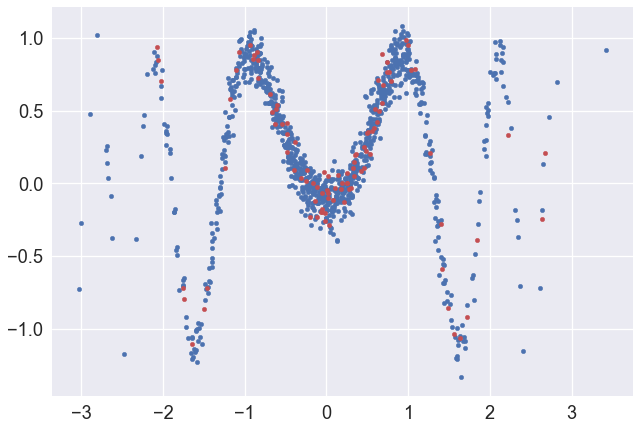

In [25]:
plt.scatter(x_train, y_train, s=20.0);
plt.scatter(x_test, y_test, s=20.0,
            color=sns.color_palette().as_hex()[2]);

In [26]:
# MODEL A
def neural_network_with_2_layers(x, W_0, W_1, b_0, b_1):
    h = tf.nn.tanh(tf.matmul(x, W_0) + b_0)
    h = tf.matmul(h, W_1) + b_1
    return tf.reshape(h, [-1])

dim = 10  # layer dimensions

W_0 = Normal(loc=tf.zeros([D, dim]),
             scale=tf.ones([D, dim]))
W_1 = Normal(loc=tf.zeros([dim, 1]),
             scale=tf.ones([dim, 1]))
b_0 = Normal(loc=tf.zeros(dim),
             scale=tf.ones(dim))
b_1 = Normal(loc=tf.zeros(1),
             scale=tf.ones(1))

x = tf.placeholder(tf.float32, [N, D])
y = Normal(loc=neural_network_with_2_layers(x, W_0, W_1, b_0, b_1),
           scale=tf.ones(N) * 0.1)  # constant noise

In [11]:
# BACKWARD MODEL A
q_W_0 = Normal(loc=tf.Variable(tf.random_normal([D, dim])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, dim]))))
q_W_1 = Normal(loc=tf.Variable(tf.random_normal([dim, 1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([dim, 1]))))
q_b_0 = Normal(loc=tf.Variable(tf.random_normal([dim])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([dim]))))
q_b_1 = Normal(loc=tf.Variable(tf.random_normal([1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))

In [12]:
# INFERENCE A
# this will take a couple of minutes
inference = ed.KLqp(latent_vars={W_0: q_W_0, b_0: q_b_0,
                                 W_1: q_W_1, b_1: q_b_1},
                    data={x: x_train, y: y_train})
inference.run(n_samples=10, n_iter=25000)

25000/25000 [100%] ██████████████████████████████ Elapsed: 302s | Loss: 1436.613


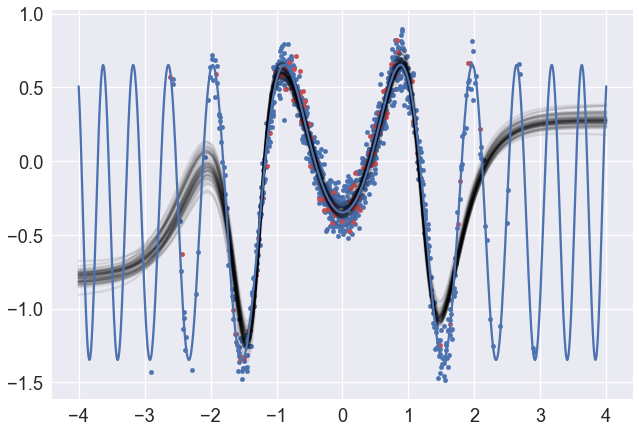

In [13]:
# CRITICISM A
plt.scatter(x_train, y_train, s=20.0);  # blue
plt.scatter(x_test, y_test, s=20.0,  # red
            color=sns.color_palette().as_hex()[2]);

xp = tf.placeholder(tf.float32, [1000, D])
[plt.plot(np.linspace(-4.0, 4.0, 1000),
          sess.run(neural_network_with_2_layers(xp,
                                                q_W_0, q_W_1,
                                                q_b_0, q_b_1),
                   {xp: np.linspace(-4.0, 4.0, 1000)[:, np.newaxis]}),
          color='black', alpha=0.1)
 for _ in range(50)];

plt.plot(np.linspace(-4.0, 4.0, 1000),
         sess.run(target_function(xp),  # blue
                  {xp: np.linspace(-4.0, 4.0, 1000)[:, np.newaxis]}));

In [14]:
xp = tf.placeholder(tf.float32, [Np, D])
y_post = Normal(loc=neural_network_with_2_layers(xp,
                                                 q_W_0, q_W_1,
                                                 q_b_0, q_b_1),
                scale=tf.ones(Np) * 0.1)

In [15]:
print("Mean squared error on test data:")
print(ed.evaluate('mean_squared_error', data={xp: x_test, y_post: y_test}))

print("Mean absolute error on test data:")
print(ed.evaluate('mean_absolute_error', data={xp: x_test, y_post: y_test}))

Mean squared error on test data:
0.0429436
Mean absolute error on test data:
0.127825


In [16]:
# MODEL B
def neural_network_with_3_layers(x, W_0, W_1, W_2, b_0, b_1, b_2):
    h = tf.tanh(tf.matmul(x, W_0) + b_0)
    h = tf.tanh(tf.matmul(h, W_1) + b_1)
    h = tf.matmul(h, W_2) + b_2
    return tf.reshape(h, [-1])

dim = 10  # layer dimensions

W_0 = Normal(loc=tf.zeros([D, dim]),
             scale=tf.ones([D, dim]))
W_1 = Normal(loc=tf.zeros([dim, dim]),
             scale=tf.ones([dim, dim]))
W_2 = Normal(loc=tf.zeros([dim, 1]),
             scale=tf.ones([dim, 1]))
b_0 = Normal(loc=tf.zeros(dim),
             scale=tf.ones(dim))
b_1 = Normal(loc=tf.zeros(dim),
             scale=tf.ones(dim))
b_2 = Normal(loc=tf.zeros(1),
             scale=tf.ones(1))

x = tf.placeholder(tf.float32, [N, D])
y = Normal(loc=neural_network_with_3_layers(x, W_0, W_1, W_2, b_0, b_1, b_2),
           scale=tf.ones(N) * 0.1)  # constant noise

In [17]:
# BACKWARD MODEL B
q_W_0 = Normal(loc=tf.Variable(tf.random_normal([D, dim])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, dim]))))
q_W_1 = Normal(loc=tf.Variable(tf.random_normal([dim, dim])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([dim, dim]))))
q_W_2 = Normal(loc=tf.Variable(tf.random_normal([dim, 1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([dim, 1]))))
q_b_0 = Normal(loc=tf.Variable(tf.random_normal([dim])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([dim]))))
q_b_1 = Normal(loc=tf.Variable(tf.random_normal([dim])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([dim]))))
q_b_2 = Normal(loc=tf.Variable(tf.random_normal([1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))

In [18]:
# INFERENCE B
# this will take ten minutes or longer
inference = ed.KLqp(latent_vars={W_0: q_W_0, b_0: q_b_0,
                                 W_1: q_W_1, b_1: q_b_1,
                                 W_2: q_W_2, b_2: q_b_2},
                    data={x: x_train, y: y_train})
inference.run(n_samples=10, n_iter=100000)

100000/100000 [100%] ██████████████████████████████ Elapsed: 1548s | Loss: 2913.215


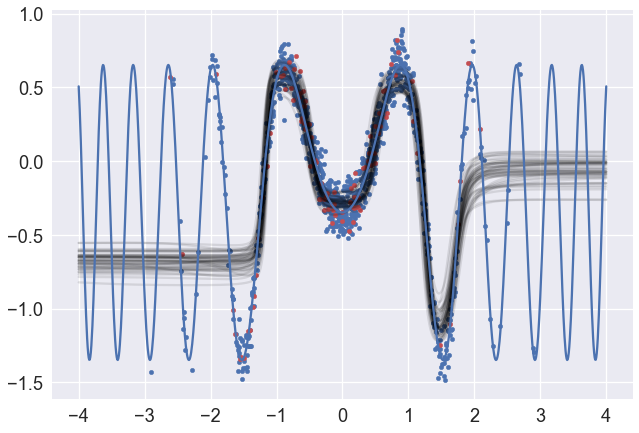

In [19]:
# CRITICISM B
plt.scatter(x_train, y_train, s=20.0);  # blue
plt.scatter(x_test, y_test, s=20.0,  # red
            color=sns.color_palette().as_hex()[2]);

xp = tf.placeholder(tf.float32, [1000, D])
[plt.plot(np.linspace(-4.0, 4.0, 1000),
          sess.run(neural_network_with_3_layers(xp,
                                                q_W_0, q_W_1, q_W_2,
                                                q_b_0, q_b_1, q_b_2),
                   {xp: np.linspace(-4.0, 4.0, 1000)[:, np.newaxis]}),
          color='black', alpha=0.1)
 for _ in range(50)];

plt.plot(np.linspace(-4.0, 4.0, 1000),
         sess.run(target_function(xp),  # blue
                  {xp: np.linspace(-4.0, 4.0, 1000)[:, np.newaxis]}));

In [20]:
xp = tf.placeholder(tf.float32, [Np, D])
y_post = Normal(loc=neural_network_with_3_layers(xp,
                                                 q_W_0, q_W_1, q_W_2,
                                                 q_b_0, q_b_1, q_b_2),
                scale=tf.ones(Np) * 0.1)

In [21]:
print("Mean squared error on test data:")
print(ed.evaluate('mean_squared_error', data={xp: x_test, y_post: y_test}))

print("Mean absolute error on test data:")
print(ed.evaluate('mean_absolute_error', data={xp: x_test, y_post: y_test}))

Mean squared error on test data:
0.0756396
Mean absolute error on test data:
0.165928


# K-sided Die

In [ ]:
from edward.models import Categorical, Dirichlet, Empirical

In [ ]:
def build_dataset(N, K, fairness):
    probs = Dirichlet(concentration=tf.ones([K]) * fairness)
    c = Categorical(probs=probs, sample_shape=N)
    return sess.run([probs, c])

In [ ]:
# DATA: 500D3
N = 500  # number of data points (dice rolls)
K = 3  # number of components (sides of the die)
fairness = 1.0  # the larger the fairer

In [ ]:
probs_true, c_train = build_dataset(N, K, fairness)

In [ ]:
probs_true

In [ ]:
sum(probs_true)

In [ ]:
c_train

In [ ]:
# FORWARD MODEL
probs = Dirichlet(concentration=tf.ones([K]))  # generalization of Beta
c = Categorical(probs=probs, sample_shape=N)  # generalization of Bernoulli

In [ ]:
# INFERENCE
probs_cond = ed.complete_conditional(probs)
probs_post = ed.copy(probs_cond, {c: c_train})

In [ ]:
# the posterior is again a Dirichlet
sess.run({key: val for
          key, val in six.iteritems(probs_post.parameters)
          if isinstance(val, tf.Tensor)})

In [ ]:
# CRITICISM
x, y = zip(*probs_post.sample(2000)[:,:2].eval())
sns.kdeplot(np.array(x), np.array(y), shade=True, shade_lowest=False)
plt.axvline(x=probs_true[0]);  # blue
plt.axhline(y=probs_true[1], c=sns.color_palette()[2]);  # red

# Semisupervised Classification

In [ ]:
from edward.models import (Categorical, Dirichlet, InverseGamma,
                           ParamMixture, MultivariateNormalDiag,
                           Normal)

In [ ]:
def build_dataset(N, Np, probs, means, vars):
    c = Categorical(probs=tf.tile(tf.reshape(probs, [1, K]),
                                  [N + Np, 1]))
    x = Normal(loc=tf.gather(means, c),
               scale=tf.gather(tf.sqrt(vars), c))
    class_samples, feature_samples = sess.run([c, x])
    ((c_samples, cp_samples),
     (x_samples, xp_samples)) = map(lambda l: (l[:N], l[N:]),
                                    sess.run([c, x]))
    return [c_samples, x_samples, cp_samples, xp_samples]

In [ ]:
# DATA
N = 100  # number of labelled data points
Np = 1000  # number of unlabelled data points
K = 3  # number of classes
D = 2  # number of features

(c_train, x_train, cp_true, xp_train) = build_dataset(
    N, Np,
    probs=[0.65, 0.1, 0.25],
    means=[[-1.0, 0.0], [1.0, 0.5], [0.5, -1.0]], 
    vars=[[1.0, 5.0], [0.25, 20.], [3.0, 2.0]])

In [ ]:
# FORWARD MODEL
class_concentration = 1.0
loc = 0.
var_concentration = 0.5
var_rate = 0.5
sample_size = 1.0

probs = Dirichlet(concentration=tf.ones([K]) * class_concentration)  # class prevalence
var = InverseGamma(concentration=tf.ones([K, D]) * var_concentration,
                   rate=tf.ones([K, D]) * var_rate)  # variance of features
mean = Normal(loc=tf.ones([K, D]) * loc,
              # scale=tf.sqrt(var) / tf.sqrt(sample_size))
              scale=tf.ones([K, D]))  # means of features

x = ParamMixture(mixing_weights=probs,
                 component_params={'loc': mean,
                                   'scale_diag': tf.sqrt(var)},
                 component_dist=MultivariateNormalDiag,
                 sample_shape=N)  # features for labelled observations
c = x.cat  # class labels for labelled observations

xp = ParamMixture(mixing_weights=probs,
                  component_params={'loc': mean,
                                    'scale_diag': tf.sqrt(var)},
                  component_dist=MultivariateNormalDiag,
                  sample_shape=Np)  # features for unlabelled observations
cp = xp.cat  # class labels for unlabelled observations

In [ ]:
# BACKWARD MODEL
T = 10000  # number of empirical samples

q_probs = Empirical(params=tf.Variable(tf.ones([T, K]) / K))
q_var = Empirical(params=tf.Variable(tf.ones([T, K, D])))
q_mean = Empirical(params=tf.Variable(tf.zeros([T, K, D])))
q_cp = Empirical(params=tf.Variable(tf.zeros([T, Np], dtype=tf.int32)))

In [ ]:
# INFERENCE
inference = ed.Gibbs(latent_vars={probs: q_probs,
                                  var: q_var,
                                  mean: q_mean,
                                  cp: q_cp},
                     data={c: c_train,
                           x: x_train,
                           xp: xp_train})
inference.run()

In [ ]:
# CRITICISM
fig = plt.figure()
ax = plt.axes(xlim=(-4.5, 3), ylim=(-15, 15))
for k in range(K):
    q_mean_samples = tf.reshape(tf.strided_slice(q_mean.params.eval(),
                                                 [int(T/2), k, 0],
                                                 [T, K, 2],
                                                 [1, K, 1]),
                                [int(T/2), 2]).eval()
    cmap = sns.light_palette(color=sns.color_palette().as_hex()[k], as_cmap=True)
    sns.kdeplot(q_mean_samples[:, 0], q_mean_samples[:, 1],
                cmap=cmap, shade=True, shade_lowest=False)

In [ ]:
# inferred classes for xp data
fig = plt.figure()
ax = plt.axes(xlim=(-4.5, 3), ylim=(-15, 15))
scat = ax.scatter(xp_train[:, 0], xp_train[:, 1], s=20.0)

scat.set_array(q_cp.params[-1].eval())  # use the last sample
scat.set_cmap(ListedColormap(sns.color_palette().as_hex()))
scat.set_norm(Normalize(vmin=0, vmax=len(sns.color_palette())-1))

In [ ]:
# true classes for xp data
fig = plt.figure()
ax = plt.axes(xlim=(-4.5, 3), ylim=(-15, 15))
scat = ax.scatter(xp_train[:, 0], xp_train[:, 1], s=20.0)

scat.set_array(cp_true)  # use the true class label
scat.set_cmap(ListedColormap(sns.color_palette().as_hex()))
scat.set_norm(Normalize(vmin=0, vmax=len(sns.color_palette())-1))

In [ ]:
#ed.criticisms.binary_accuracy(cp_true, q_cp).eval()
ed.criticisms.binary_accuracy(cp_true, q_cp.params[int(T/2):]).eval()

In [ ]:
# this takes a couple of minutes
fig = plt.figure()
ax = plt.axes(xlim=(-4.5, 3), ylim=(-15, 15))
scat = ax.scatter(xp_train[:, 0], xp_train[:, 1], s=20.0)

def init():
    scat.set_array(q_cp.params[0].eval())
    scat.set_cmap(ListedColormap(sns.color_palette().as_hex()))
    scat.set_norm(Normalize(vmin=0, vmax=len(sns.color_palette())-1))
    return (scat,)

def animate(i):
    scat.set_array(q_cp.params[i].eval())
    return (scat,)

anim = FuncAnimation(fig, animate, init_func=init,
                     frames=range(1, 100), interval=20, blit=True)

display_animation(anim)

In [ ]:
filter(lambda xp:   0.5 < xp[0][0] < 1.0 and
                  -0.25 < xp[0][1] < 0.25,
       zip(xp_train, range(len(xp_train))))

In [ ]:
sns.countplot(q_cp.params[int(T/2):, 0].eval(), order=range(K))

# For The Adventurous: Bayesian Probabilistic Matrix Factorization

In [ ]:
from edward.models import Bernoulli, Normal

In [ ]:
def build_dataset(U, V, N, M, noise=0.1):
    loc = tf.matmul(tf.transpose(U), V)
    R = Normal(loc=loc, scale=tf.ones(loc.shape) * noise)
    return R

def build_indicators(N, M, prob=0.5):
    I = Bernoulli(probs=tf.ones([N, M]) * prob)
    return I

In [ ]:
# DATA
N = 50  # number of users
M = 60  # number of movies
D = 3  # number of latent factors

# true latent factors
U_true = Normal(loc=tf.zeros([D, N]), scale=tf.ones([D, N])).eval()
V_true = Normal(loc=tf.zeros([D, M]), scale=tf.ones([D, M])).eval()

In [ ]:
R_true = build_dataset(U_true, V_true, N, M).eval()
I_train = build_indicators(N, M).eval()

In [ ]:
# FORWARD MODEL
I = tf.placeholder(tf.bool, [N, M])
U = Normal(loc=tf.zeros([D, N]), scale=tf.ones([D, N]))
V = Normal(loc=tf.zeros([D, M]), scale=tf.ones([D, M]))
loc = tf.matmul(tf.transpose(U), V)
scale = tf.ones([N, M])
R_obs = Normal(loc=tf.boolean_mask(loc, I),
               scale=tf.boolean_mask(scale, I))

In [ ]:
# BACKWARD MODEL
q_U = Normal(loc=tf.Variable(tf.random_normal([D, N])),
             scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, N]))))
q_V = Normal(loc=tf.Variable(tf.random_normal([D, M])),
             scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, M]))))

In [ ]:
# INFERENCE
inference = ed.KLqp(latent_vars={U: q_U,
                                 V: q_V},
                    data={R_obs: tf.boolean_mask(R_true.astype(np.float32),
                                                 I_train.astype(bool)),
                          I: I_train.astype(bool)})
inference.run(n_samples=10, n_iter=20000)

In [ ]:
# CRITICISM
q_loc = tf.matmul(tf.transpose(q_U), q_V)
R_mis = Normal(loc=tf.boolean_mask(q_loc, tf.logical_not(I)),
               scale=tf.boolean_mask(scale, tf.logical_not(I)))

print("Mean squared error on test data:")
print(ed.evaluate('mean_squared_error',
                  data={R_mis: tf.boolean_mask(R_true.astype(np.float32),
                                               tf.logical_not(I_train.astype(bool))),
                        I: I_train.astype(bool)}))

In [ ]:
plt.imshow(R_true,
           cmap=sns.diverging_palette(240, 10, n=9, as_cmap=True));

In [ ]:
R_est = tf.matmul(tf.transpose(q_U), q_V).eval()

In [ ]:
plt.imshow(R_est,
           cmap=sns.diverging_palette(240, 10, n=9, as_cmap=True));

In [ ]:
plt.imshow(Normal(loc=tf.matmul(tf.transpose(q_U), q_V),
                  scale=scale).mean().eval(),
           cmap=sns.diverging_palette(240, 10, n=9, as_cmap=True));